# Rock Physics Q-inversion of a volcanic flow

In [592]:
from importlib import reload
import volcaniQ as vq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

In [594]:
reload(vq)
data = vq.CleanReadCSV()

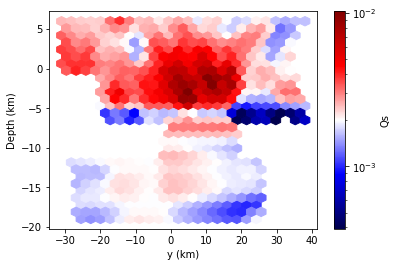

<Figure size 758160x758160 with 0 Axes>

In [595]:
data.hexplot(plot="Qs", direction="x", value=-0., func=(lambda x: 1/x), bins='log')


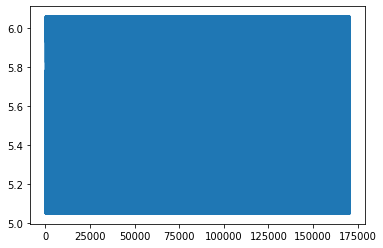

In [607]:

np.sqrt((data.data.K + 4/3 *data.data.μ)/(.8*data.data.ρ + .2))